In [780]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting -- autoregressive forcasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster


# Modelling and Forecasting -- boosting method
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [844]:
data = pd.read_csv('../data/data_forcast.csv', index_col=False)

In [845]:
data

,State,Date,zori,cpi,property_tax,population,property_crime,burglary,larceny,motor_vehicle_theft,gdp,personal_consumption,personal_income,unemployment_rates,house_price_index,housing_units
0,AL,2015-02-01,757.299395,234.722,531.469599,4853875.0,144785.0,35265.0,99182.0,10338.0,189878.6,152755.9,1.872202e+11,6.1,355.30,886000.0
1,AL,2015-03-01,760.788563,236.119,531.469599,4853875.0,144785.0,35265.0,99182.0,10338.0,189878.6,152755.9,1.872202e+11,6.1,355.30,960000.0
2,AL,2015-04-01,765.762525,236.599,531.469599,4853875.0,144785.0,35265.0,99182.0,10338.0,191535.8,152755.9,1.886909e+11,6.1,355.30,1190000.0
3,AL,2015-05-01,764.761611,237.805,531.469599,4853875.0,144785.0,35265.0,99182.0,10338.0,191535.8,152755.9,1.886909e+11,6.1,360.36,1079000.0
4,AL,2015-06-01,770.767118,238.638,531.469599,4853875.0,144785.0,35265.0,99182.0,10338.0,191535.8,152755.9,1.886909e+11,6.2,360.36,1205000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2663,WY,2019-07-01,512.436401,256.571,2065.828782,580116.0,9097.0,1394.0,6981.0,722.0,38832.8,24839.0,3.548560e+10,3.7,441.19,1232000.0
2664,WY,2019-08-01,515.675242,256.558,2065.828782,580116.0,9097.0,1394.0,6981.0,722.0,38832.8,24839.0,3.548560e+10,3.8,445.13,1370000.0
2665,WY,2019-09-01,516.000366,256.759,2065.828782,580116.0,9097.0,1394.0,6981.0,722.0,38832.8,24839.0,3.548560e+10,4.0,445.13,1297000.0
2666,WY,2019-10-01,514.886048,257.346,2065.828782,580116.0,9097.0,1394.0,6981.0,722.0,39186.5,24839.0,3.571410e+10,4.1,445.13,1328000.0


In [847]:
def selectAndSplitByState(data, state_name):
    state_data = data[data['State'] == state_name]
    end_train = '2018-12-01'
    end_validation = '2019-05-01'
    mask_data_train = (state_data['Date'] < end_train)
    mask_data_val   = (state_data['Date'] >= end_train) & (state_data['Date'] < end_validation)
    mask_data_test  = (state_data['Date'] > end_validation)
    return state_data, state_data.loc[mask_data_train], state_data.loc[mask_data_val], state_data.loc[mask_data_test]

## split data into only train-test
def splitTrainTestByState(data, state_name):
    state_data = data[data['State'] == state_name]
    end_train = '2019-05-01'
    mask_data_train = (state_data['Date'] <= end_train)
    mask_data_test  = (state_data['Date'] > end_train)
    return state_data, state_data.loc[mask_data_train], state_data.loc[mask_data_test]

# Recursive autoregressive forecasting

In [848]:
data

,State,Date,zori,cpi,property_tax,population,property_crime,burglary,larceny,motor_vehicle_theft,gdp,personal_consumption,personal_income,unemployment_rates,house_price_index,housing_units
0,AL,2015-02-01,757.299395,234.722,531.469599,4853875.0,144785.0,35265.0,99182.0,10338.0,189878.6,152755.9,1.872202e+11,6.1,355.30,886000.0
1,AL,2015-03-01,760.788563,236.119,531.469599,4853875.0,144785.0,35265.0,99182.0,10338.0,189878.6,152755.9,1.872202e+11,6.1,355.30,960000.0
2,AL,2015-04-01,765.762525,236.599,531.469599,4853875.0,144785.0,35265.0,99182.0,10338.0,191535.8,152755.9,1.886909e+11,6.1,355.30,1190000.0
3,AL,2015-05-01,764.761611,237.805,531.469599,4853875.0,144785.0,35265.0,99182.0,10338.0,191535.8,152755.9,1.886909e+11,6.1,360.36,1079000.0
4,AL,2015-06-01,770.767118,238.638,531.469599,4853875.0,144785.0,35265.0,99182.0,10338.0,191535.8,152755.9,1.886909e+11,6.2,360.36,1205000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2663,WY,2019-07-01,512.436401,256.571,2065.828782,580116.0,9097.0,1394.0,6981.0,722.0,38832.8,24839.0,3.548560e+10,3.7,441.19,1232000.0
2664,WY,2019-08-01,515.675242,256.558,2065.828782,580116.0,9097.0,1394.0,6981.0,722.0,38832.8,24839.0,3.548560e+10,3.8,445.13,1370000.0
2665,WY,2019-09-01,516.000366,256.759,2065.828782,580116.0,9097.0,1394.0,6981.0,722.0,38832.8,24839.0,3.548560e+10,4.0,445.13,1297000.0
2666,WY,2019-10-01,514.886048,257.346,2065.828782,580116.0,9097.0,1394.0,6981.0,722.0,39186.5,24839.0,3.571410e+10,4.1,445.13,1328000.0


In [849]:
end_train = '2019-05-01'
state_data, data_train, data_test = splitTrainTestByState(data, 'VA') ## select state name

# ForecasterAutoreg

With the ForecasterAutoreg class, a model is created and trained from a RandomForestRegressor regressor with a time window of 6 lags. This means that the model uses the previous 6 months as predictors.

In [850]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=data_train['zori'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 51] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-12-04 22:48:29 
Last fit date: 2022-12-04 22:48:29 
Skforecast version: 0.5.1 
Python version: 3.9.12 

### Predictions

Once the model is trained, the test data is predicted (12 months into the future)

In [851]:
# Predictions
# ==============================================================================
steps = 6
predictions = forecaster.predict(steps=steps)
predictions.head(6)

6     1613.596184
7     1613.596184
8     1613.596184
9     1613.596184
10    1613.596184
11    1613.596184
Name: pred, dtype: float64

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings s

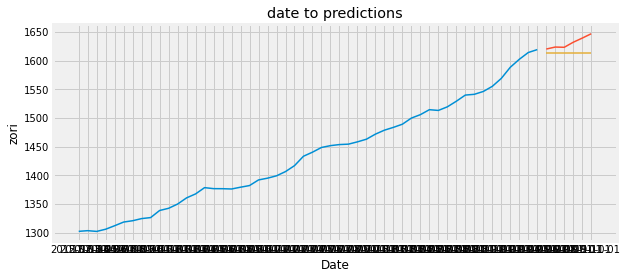

In [852]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(data_train['Date'], data_train['zori'])
ax.plot(data_test['Date'], data_test['zori'])
ax.plot(data_test['Date'], predictions)

ax.set(xlabel="Date",
       ylabel="zori",
       title="date to predictions")
plt.show()

### Prediction error in the test set

The error that the model makes in its predictions is quantified. In this case, the metric used is the mean squared error (mse).

In [854]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['zori'],
                y_pred = predictions,
                squared=False
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 19.547253704436887


### Hyperparameter tuning

The trained ForecasterAutoreg uses a 6 lag time window and a Random Forest model with the default hyperparameters. However, there is no reason why these values are the most suitable. In order to identify the best combination of lags and hyperparameters, the Skforecast library provides the grid_search_forecaster function. It compares the results obtained with each model configuration.

In [883]:
# Hyperparameter Grid search
# ==============================================================================
steps = 6
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [3, 4, 5, 6]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 200, 300, 400],
              'max_depth': [3, 4, 5, 7, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['zori'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True, #no need to create and train forecaster again, it's already the best
                        verbose            = False
               )

Number of models compared: 80.


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [01:17<00:00, 19.30s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 5, 'n_estimators': 400}
  Backtesting metric: 915.1729975614616



In [884]:
# Grid Search results
# ==============================================================================
results_grid.head(3)

,lags,params,mean_squared_error,max_depth,n_estimators
11,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 400}",915.172998,5,400
19,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 400}",916.484422,10,400
15,"[1, 2, 3]","{'max_depth': 7, 'n_estimators': 400}",917.638338,7,400


The best results are obtained using a time window of 3 lags and a Random Forest set up of {'max_depth': 3, 'n_estimators': 400}.

### Final model

Finally, a ForecasterAutoreg is trained with the optimal configuration found by validation. This step is not necessary if return_best = True is specified in the grid_search_forecaster function.

In [885]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=400, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 3
             )

forecaster.fit(y=data_train['zori'])

In [886]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

In [887]:
predictions

3    1604.656740
4    1604.631372
5    1604.631372
6    1604.631372
7    1604.631372
8    1604.631372
Name: pred, dtype: float64

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings s

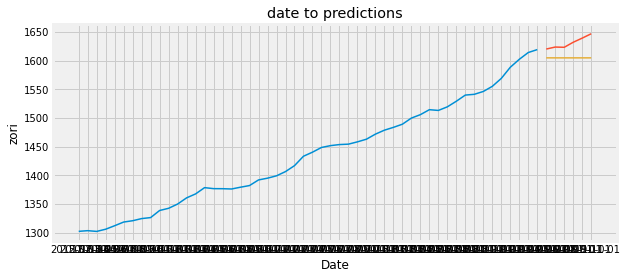

In [888]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(data_train['Date'], data_train['zori'])
ax.plot(data_test['Date'], data_test['zori'])
ax.plot(data_test['Date'], predictions)

ax.set(xlabel="Date",
       ylabel="zori",
       title="date to predictions")
plt.show()

In [889]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['zori'],
                y_pred = predictions,
                squared=False
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 27.711199999395706


## Predictors importance

Since the ForecasterAutoreg object uses Scikit-learn models, the importance of predictors can be accessed once trained. When the regressor used is a LinearRegression(), Lasso() or Ridge(), the coefficients of the model reflect their importance. In GradientBoostingRegressor() or RandomForestRegressor() regressors, the importance of predictors is based on impurity.

In [890]:
# Predictors importance
# ==============================================================================
forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.35697
1,lag_2,0.33346
2,lag_3,0.30957


## Recursive autoregressive forecasting with exogenous variables

In the previous example, only lags of the predicted variable itself have been used as predictors. In certain scenarios, it is possible to have information about other variables, whose future value is known, so could serve as additional predictors in the model.

Continuing with the previous example, a new variable whose behavior is correlated with the modeled time series and it is wanted to incorporate as a predictor is simulated. The same applies to multiple exogenous variables.


In [891]:
data_x = state_data.iloc[:, 3:]
data_x.columns

Index(['cpi', 'property_tax', 'population', 'property_crime', 'burglary',
       'larceny', 'motor_vehicle_theft', 'gdp', 'personal_consumption',
       'personal_income', 'unemployment_rates', 'house_price_index',
       'housing_units'],
      dtype='object')

In [892]:
exog_variables = [column for column in data_x.columns]
exog_variables

['cpi',
 'property_tax',
 'population',
 'property_crime',
 'burglary',
 'larceny',
 'motor_vehicle_theft',
 'gdp',
 'personal_consumption',
 'personal_income',
 'unemployment_rates',
 'house_price_index',
 'housing_units']

In [893]:
end_train

'2019-05-01'

In [894]:
data_train.loc[data_train['Date'] <= end_train, exog_variables].shape

(52, 13)

In [895]:
data_train.shape

(52, 16)

In [896]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 3
             )

forecaster.fit(y=data_train['zori'], exog = data_train.loc[data_train['Date'] <= end_train, exog_variables])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3] 
Transformer for y: None 
Transformer for exog: None 
Window size: 3 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['cpi', 'property_tax', 'population', 'property_crime', 'burglary', 'larceny', 'motor_vehicle_theft', 'gdp', 'personal_consumption', 'personal_income', 'unemployment_rates', 'house_price_index', 'housing_units'] 
Training range: [0, 51] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-12-

In [897]:
data_test.shape

(6, 16)

In [898]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps = 6, exog=data_test.loc[data_test['Date'] > end_train, exog_variables])

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings s

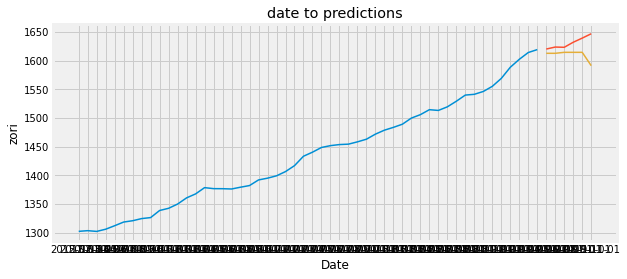

In [899]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(data_train['Date'], data_train['zori'])
ax.plot(data_test['Date'], data_test['zori'])
ax.plot(data_test['Date'], predictions)

ax.set(xlabel="Date",
       ylabel="zori",
       title="date to predictions")
plt.show()

In [900]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['zori'],
                y_pred = predictions,
                squared=False
            )

print(f"Test error (rmse): {error_mse}")


Test error (rmse): 26.639296888571767


### the test error is too large, skip hyperparameter tunning

## Boosting method

## 02/01/2015 - 12/01/2018 as train data, 01/01/2019 - 05/01/2019 as validation data, 06/01/2019 - 11/01/2019 as test data (duration we want to predict)

In [901]:
end_train = '2018-12-01'
end_validation = '2019-05-01'
state_data, data_train, data_val, data_test = selectAndSplitByState(data, 'VA') ## select state name

In [902]:
data_test.shape

(6, 16)

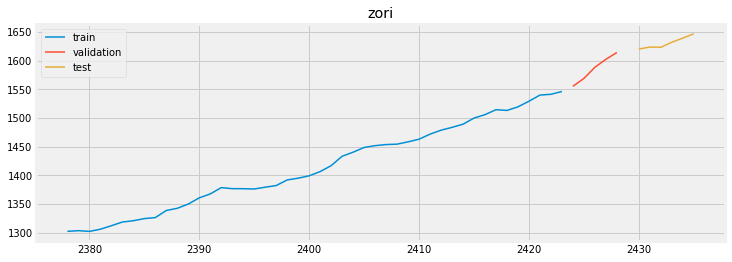

In [903]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_train['zori'].plot(ax=ax, label='train')
data_val['zori'].plot(ax=ax, label='validation')
data_test['zori'].plot(ax=ax, label='test')
ax.set_title('zori')
ax.legend();

## Autocorrelation plots

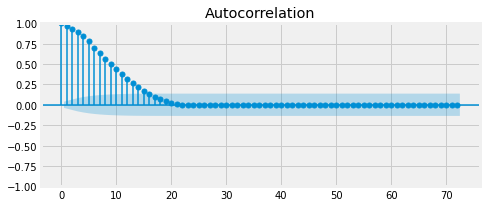

In [904]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(data['zori'], ax=ax, lags=72)
plt.show()

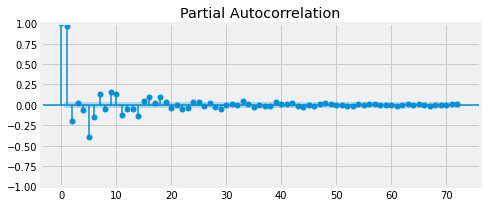

In [905]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(data['zori'], ax=ax, lags=72, method='ywm')
plt.show()

The autocorrelation and partial autocorrelation plots show a clear association between one month's zori index and previous months, as well as between one month's demand and the same month's demand on years. This type of correlation is an indication that autoregressive models can work well.

# 1. XGBoost

In [931]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 3
                )

forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None) 
Lags: [1 2 3] 
Transformer for y: None 
Transformer for exog: None 
Window size: 3 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'objective':

In [932]:
int(len(data_train))

46

In [933]:
len(state_data.loc[state_data['Date'] < end_validation, 'zori'])

51

In [934]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 400, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }

# Lags used as predictors
# lags_grid = [11, 22, 33, [1, 2, 3, 23, 24, 25]]


results_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = state_data.loc[state_data['Date'] < end_validation, 'zori'], # Train and validation data
        exog               = state_data.loc[state_data['Date'] < end_validation, exog_variables],
        param_grid         = param_grid,
#         lags_grid          = lags_grid,
        steps              = 6,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(data_train)), # Model is trained with trainign data
        fixed_train_size   = False,
        return_best        = True,
        verbose            = False
        )

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:05<00:00,  5.21s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 2019.0665799540207



In [935]:
# Results of grid search
# ==============================================================================
results_grid.head(5)

,lags,params,mean_squared_error,learning_rate,max_depth,n_estimators
17,"[1, 2, 3]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",2019.066580,0.1,10.0,500.0
16,"[1, 2, 3]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",2019.066580,0.1,10.0,400.0
14,"[1, 2, 3]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",2027.277244,0.1,5.0,500.0
13,"[1, 2, 3]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",2027.277244,0.1,5.0,400.0
11,"[1, 2, 3]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",2027.735456,0.1,3.0,500.0


The best results are obtained using a time window of 6 lags and a Random Forest set up of {'max_depth': 10, 'n_estimators': 500}.

In [936]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = state_data['zori'],
    initial_train_size = len(state_data.loc[state_data['Date'] < end_validation]),
    fixed_train_size   = False,
    steps      = 6,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
    )

print(f"Backtest error: {metric}")

Backtest error: 321.4289447062937


In [937]:
# Predictions
# ==============================================================================
predictions['pred']

3    1613.933594
4    1613.933594
5    1613.933594
6    1613.933594
7    1613.933594
8    1613.933594
3    1613.933594
Name: pred, dtype: float64

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings s

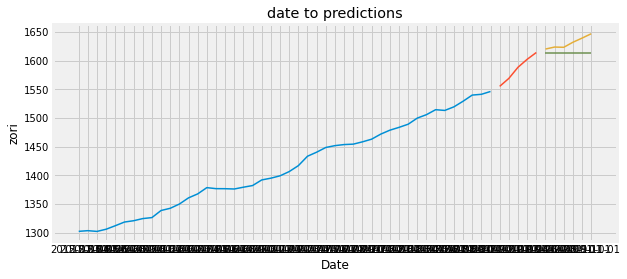

In [938]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(data_train['Date'],
        data_train['zori'])
ax.plot(data_val['Date'],
        data_val['zori'])
ax.plot(data_test['Date'],
        data_test['zori'])
ax.plot(data_test['Date'], predictions['pred'][:-1])
ax.set(xlabel="Date",
       ylabel="zori",
       title="date to predictions")
plt.show()

In [939]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['zori'],
                y_pred = predictions[:-1],
                squared=False
            )

print(f"Test error (rmse): {error_mse}")

Test error (rmse): 19.253776763216162


In [940]:
# Extract feature importance
# ==============================================================================
importance = forecaster.get_feature_importance()
importance

,feature,importance
0,lag_1,0.181182
1,lag_2,0.176774
2,lag_3,0.000115
3,cpi,0.092738
4,property_tax,0.000000
5,population,0.000000
6,property_crime,0.000000
7,burglary,0.000000
8,larceny,0.000004
9,motor_vehicle_theft,0.000000


## 2. LightGBM

In [915]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 3
             )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [1 2 3] 
Transformer for y: None 
Transformer for exog: None 
Window size: 3 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-12-04 23:37:07 
Last fit date: None 
Skforecast version: 0.5.1 
Python version: 3.9.12 

In [916]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 400, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
# lags_grid = [6, [1, 2, 3, 6, 7, 8, 28, 29, 30]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = state_data.loc[state_data['Date'] < end_validation, 'zori'],
                        exog               = state_data.loc[state_data['Date'] < end_validation, exog_variables],
                        param_grid         = param_grid,
#                         lags_grid          = lags_grid,
                        steps              = 6,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 8267.534543551765



In [917]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = state_data['zori'],
                            exog               = state_data[exog_variables],
                            initial_train_size = len(state_data.loc[state_data['Date'] < end_validation]),
                            fixed_train_size   = False,
                            steps              = 6,
                            refit              = False,
                            metric             = 'mean_squared_error',
                            verbose            = False
                      )

print(f"Backtest error: {metric}")

Finished loading model, total used 500 iterations
Backtest error: 12044.229656720354


In [918]:
# Extract feature importance
# ==============================================================================
importance = forecaster.get_feature_importance()
importance

,feature,importance
0,lag_1,121
1,lag_2,0
2,lag_3,0
3,cpi,0
4,property_tax,34
5,population,0
6,property_crime,0
7,burglary,0
8,larceny,0
9,motor_vehicle_theft,0


In [919]:
predictions

,pred
3,1519.66572
4,1519.66572
5,1519.66572
6,1519.66572
7,1519.66572
8,1519.66572
3,1519.66572


matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


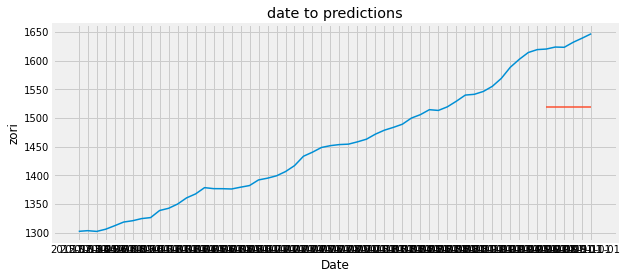

In [920]:
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(state_data['Date'],
        state_data['zori'])
ax.plot(data_test['Date'], predictions['pred'][:-1])
ax.set(xlabel="Date",
       ylabel="zori",
       title="date to predictions")
plt.show()

In [921]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['zori'],
                y_pred = predictions[:-1],
                squared=False
            )

print(f"Test error (rmse): {error_mse}")

Test error (rmse): 111.38567484020078


## 3. CatBoost

In [922]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=123, silent=True),
                lags = 3
             )

forecaster

ForecasterAutoreg 
Regressor: <catboost.core.CatBoostRegressor object at 0x7fad4c243fd0> 
Lags: [1 2 3] 
Transformer for y: None 
Transformer for exog: None 
Window size: 3 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'loss_function': 'RMSE', 'silent': True, 'random_state': 123} 
Creation date: 2022-12-04 23:38:28 
Last fit date: None 
Skforecast version: 0.5.1 
Python version: 3.9.12 

In [923]:
state_data, data_train, data_val, data_test = selectAndSplitByState(data, 'VA')

In [924]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 400, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
# lags_grid = [6, [1, 2, 3, 6, 7, 8, 13, 14, 15]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = state_data.loc[state_data['Date'] < end_validation, 'zori'],
                        exog               = state_data.loc[state_data['Date'] < end_validation, exog_variables],
                        param_grid         = param_grid,
#                         lags_grid          = lags_grid,
                        steps              = 6,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.02s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400}
  Backtesting metric: 2589.1993489148713



In [925]:
results_grid.head(5)

,lags,params,mean_squared_error,learning_rate,max_depth,n_estimators
10,"[1, 2, 3]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",2589.199349,0.1,3.0,400.0
11,"[1, 2, 3]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",2597.617867,0.1,3.0,500.0
9,"[1, 2, 3]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",2712.320764,0.1,3.0,100.0
14,"[1, 2, 3]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",3134.783407,0.1,5.0,500.0
13,"[1, 2, 3]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",3135.004138,0.1,5.0,400.0


In [926]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = state_data['zori'],
                            exog               = state_data[exog_variables],
                            initial_train_size = len(state_data.loc[state_data['Date'] < end_validation]),
                            fixed_train_size   = False,
                            steps              = 6,
                            refit              = False,
                            metric             = 'mean_squared_error',
                            verbose            = False
                      )

print(f"Backtest error: {metric}")

Backtest error: 888.0980483318027


In [927]:
# Extract feature importance
# ==============================================================================
importance = forecaster.get_feature_importance()
importance

,feature,importance
0,lag_1,1.544625
1,lag_2,24.827526
2,lag_3,7.513479
3,cpi,2.160195
4,property_tax,3.479778
5,population,4.610255
6,property_crime,4.729183
7,burglary,2.126283
8,larceny,17.779152
9,motor_vehicle_theft,0.300837


In [928]:
predictions

,pred
3,1613.704822
4,1607.790770
5,1607.790770
6,1612.984326
7,1613.704822
8,1612.930170
3,1578.140631


matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


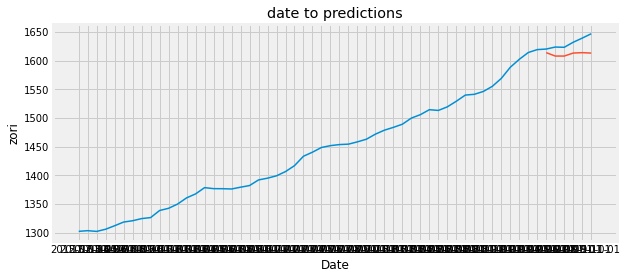

In [929]:
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(state_data['Date'],
        state_data['zori'], label='history')
# ax.plot(data_test['Date'],
#         data_test['zori'], label = 'test')
ax.plot(data_test['Date'], predictions['pred'][:-1], label = 'pred')
ax.set(xlabel="Date",
       ylabel="zori",
       title="date to predictions")
plt.show()

In [930]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['zori'],
                y_pred = predictions[:-1],
                squared=False
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 20.99214423456708
